In [1]:
import torch
from segment_anything import sam_model_registry

sam = sam_model_registry['vit_b'](checkpoint='sam_vit_b_01ec64.pth').to(device=torch.device('cpu'))

In [2]:
import cv2

image = cv2.imread('pins@high.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [3]:
from segment_anything import SamPredictor

mask_predictor = SamPredictor(sam)
mask_predictor.set_image(image_rgb)

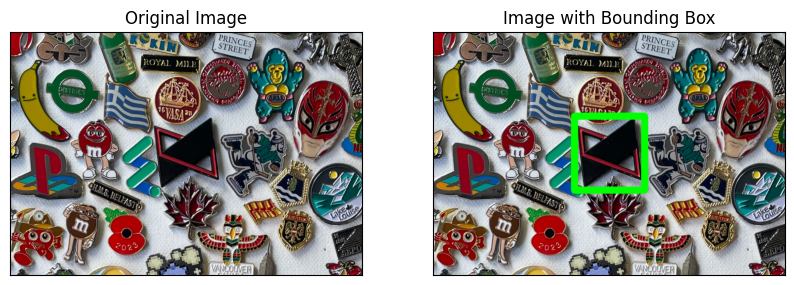

In [4]:
import numpy as np

crop_image = np.array([759-500, 913-300, 1007+500, 1174+300])

box = np.array([759, 913, 1007, 1174])


import matplotlib.pyplot as plt

def draw_annotations(image, box = None, points = None, crop = None):

    # Create a copy of the image to draw the bounding box
    original_image = image.copy()
    annotated_image = image.copy()

    if box is not None:
        # Draw the bounding box on the copied image
        cv2.rectangle(annotated_image, box[:2], box[2:], (0, 255, 0), 24)
    elif points is not None:
        for point in points:
            cv2.circle(annotated_image, point, 20, (255, 0, 0), -1)

    if crop is not None:
        original_image = original_image[crop[1]:crop[3], crop[0]:crop[2]]
        annotated_image = annotated_image[crop[1]:crop[3], crop[0]:crop[2]]

    # Create two subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Display the original image in the first subplot
    axs[0].imshow(original_image)
    axs[0].set_title('Original Image')

    # Display the image with the bounding box in the second subplot
    axs[1].imshow(annotated_image)
    axs[1].set_title('Image with Bounding Box')

    # Remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

draw_annotations(image_rgb, box=box, crop=crop_image)

In [5]:
masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True,
)

In [6]:
def extract_from_mask(image, mask, crop_box):
    # Create a new array to store the extracted image
    image_rgba = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)

    # Convert the mask to an alpha channel with values in the range [0, 255]
    alpha = (mask * 255).astype(np.uint8)

    # Copy the RGB channels
    for i in range(3):
        image_rgba[:, :, i] = image[:, :, i]

    # Set the alpha channel
    image_rgba[:, :, 3] = alpha
   
    cropped_image = image_rgba[crop_box[1]:crop_box[3], crop_box[0]:crop_box[2]]

    return cropped_image

In [7]:
def draw_masks(image, masks, scores, crop_box):

    crops = [
        extract_from_mask(image, mask, crop_box)
        for mask in masks
    ]

    # Create a new figure
    fig, axs = plt.subplots(1, len(crops), figsize=(15, 5))

    # Display the extracted images
    for i, (crop, score) in enumerate(zip(crops, scores.tolist())):
        axs[i].imshow(crop)
        axs[i].set_title(f'Crop {i + 1}, score: {score:.5f}')
        axs[i].axis('off')

    plt.show()

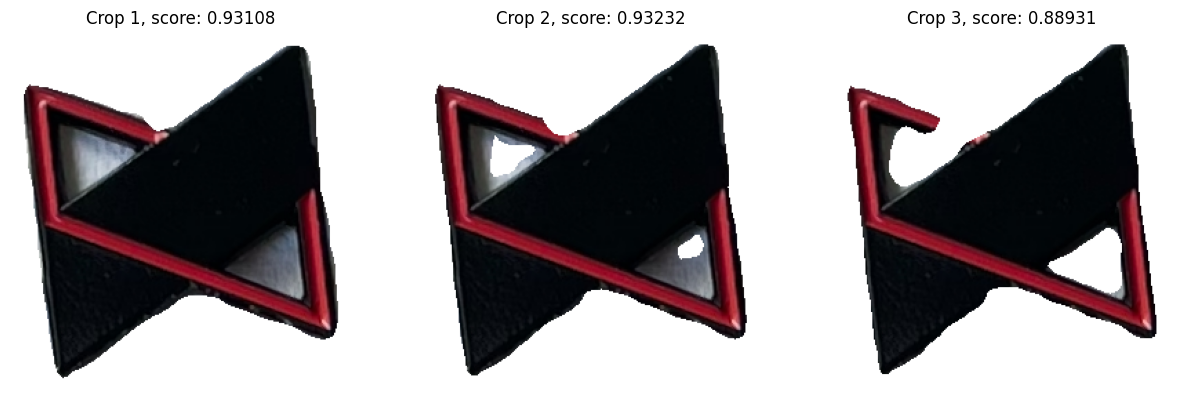

In [8]:
draw_masks(image_rgb, masks, scores, box)

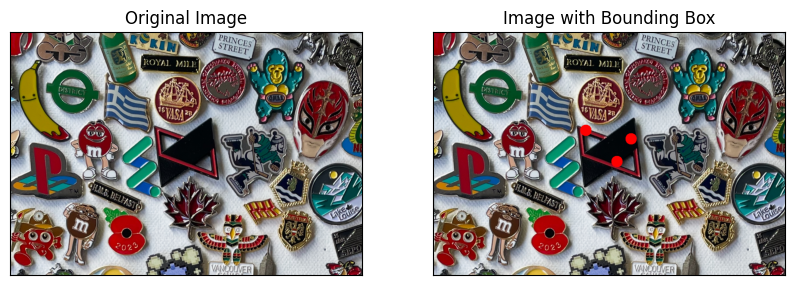

In [9]:
point_coords = np.array([
    (box[0]+40, box[1]+50),
    (box[0]+150, box[1]+160),
    (box[0]+200, box[1]+80),
])

point_labels = np.array([1, 1, 1])

draw_annotations(image_rgb, points=point_coords, crop=crop_image)


In [10]:
masks, scores, logits = mask_predictor.predict(
    point_coords=point_coords,
    point_labels=np.array([1, 1, 1]),
    multimask_output=True,
)

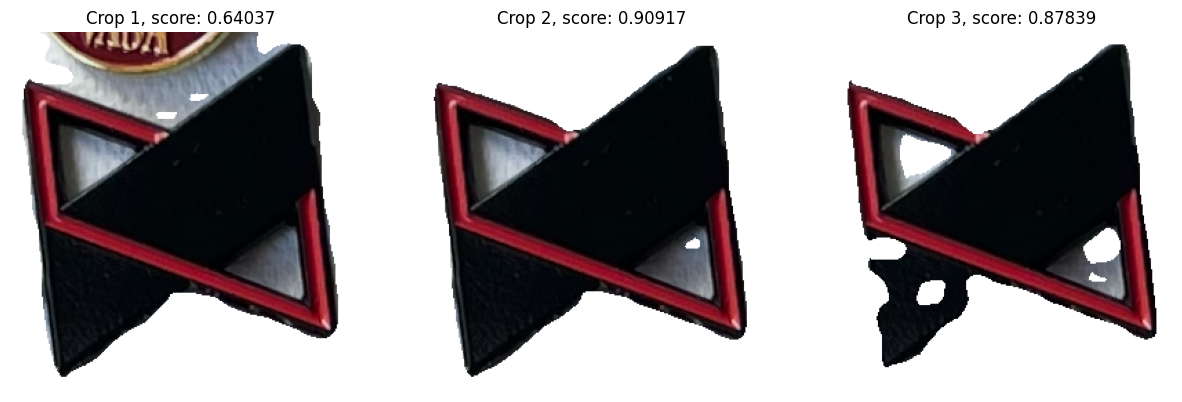

In [11]:
draw_masks(image_rgb, masks, scores, box)